In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

In [ ]:
print(help(tf.Variable))

** Reference **
> [numpy中reshape函数参数-1的意思？](https://www.zhihu.com/question/52684594)

In [5]:
batch_size = 128
test_size = 256

def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

def model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden):
    l1a = tf.nn.relu(tf.nn.conv2d(X, w,                       # l1a shape=(?, 28, 28, 32)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1],              # l1 shape=(?, 14, 14, 32)
                        strides=[1, 2, 2, 1], padding='SAME')
    l1 = tf.nn.dropout(l1, p_keep_conv)

    l2a = tf.nn.relu(tf.nn.conv2d(l1, w2,                     # l2a shape=(?, 14, 14, 64)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1],              # l2 shape=(?, 7, 7, 64)
                        strides=[1, 2, 2, 1], padding='SAME')
    l2 = tf.nn.dropout(l2, p_keep_conv)

    l3a = tf.nn.relu(tf.nn.conv2d(l2, w3,                     # l3a shape=(?, 7, 7, 128)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l3 = tf.nn.max_pool(l3a, ksize=[1, 2, 2, 1],              # l3 shape=(?, 4, 4, 128)
                        strides=[1, 2, 2, 1], padding='SAME')
    l3 = tf.reshape(l3, [-1, w4.get_shape().as_list()[0]])    # reshape to (?, 2048)
    l3 = tf.nn.dropout(l3, p_keep_conv)

    l4 = tf.nn.relu(tf.matmul(l3, w4))
    l4 = tf.nn.dropout(l4, p_keep_hidden)

    pyx = tf.matmul(l4, w_o)
    return pyx

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
print(trX.shape)
print(teX.shape)
trX = trX.reshape(-1, 28, 28, 1)  # 28x28x1 input img
print(trX.shape)
teX = teX.reshape(-1, 28, 28, 1)  # 28x28x1 input img
print(teX.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 784)
(10000, 784)
(55000, 28, 28, 1)
(10000, 28, 28, 1)


   *** test tf.random_normal function, see how it works ***

[ 0.91886818  1.14845991  1.00653291 ...,  1.09641898  1.15917027
  1.00369596]
[ 2.87061977  1.32528722  3.98091865 ...,  2.50632     1.1239934
  3.98669887]
flatten array min:  0.697049
flatten array max:  1.33896


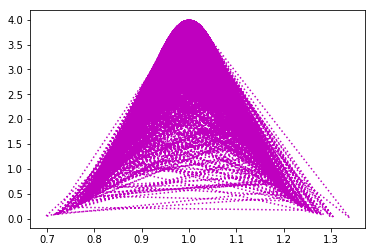

In [3]:
w = tf.random_normal([50, 50], mean = 1, stddev=0.1, seed=1)
w1 = tf.reshape(w, [-1])
def normfun(x,mu, sigma):
    pdf = np.exp(-((x - mu)**2) / (2* sigma**2)) / (sigma * np.sqrt(2*np.pi))
    return pdf
with tf.Session() as sess:
    data = sess.run(w1)
    print(data)
    y = normfun(data, 1, 0.1)
    print(y)
    print('flatten array min: ', np.min(data))
    print('flatten array max: ', np.max(data))
    plt.plot(data, y, 'm:')
    plt.show()

In [4]:
X = tf.placeholder("float", [None, 28, 28, 1])
Y = tf.placeholder("float", [None, 10])

w = init_weights([3, 3, 1, 32])       # 3x3x1 conv, 32 outputs
w2 = init_weights([3, 3, 32, 64])     # 3x3x32 conv, 64 outputs
w3 = init_weights([3, 3, 64, 128])    # 3x3x32 conv, 128 outputs
w4 = init_weights([128 * 4 * 4, 625]) # FC 128 * 4 * 4 inputs, 625 outputs
w_o = init_weights([625, 10])         # FC 625 inputs, 10 outputs (labels)

p_keep_conv = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")
py_x = model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=py_x, labels=Y))
train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
predict_op = tf.argmax(py_x, 1)

In [ ]:
# Launch the graph in a session
with tf.Session() as sess:
    # you need to initialize all variables
    tf.global_variables_initializer().run()

    for i in range(100):
        training_batch = zip(range(0, len(trX), batch_size),
                             range(batch_size, len(trX)+1, batch_size))
        for start, end in training_batch:
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end],
                                          p_keep_conv: 0.8, p_keep_hidden: 0.5})

        test_indices = np.arange(len(teX)) # Get A Test Batch
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:test_size]

        print(i, np.mean(np.argmax(teY[test_indices], axis=1) ==
                         sess.run(predict_op, feed_dict={X: teX[test_indices],
                                                         Y: teY[test_indices],
                                                         p_keep_conv: 1.0,
                                                         p_keep_hidden: 1.0})))